In [1]:
## import modules
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import seaborn as sns
import plotly.express as px
import json
from pypalettes import load_cmap
from matplotlib import colors
from shapely.geometry import box
import numpy as np
import numpyro.distributions as dist
import jax
import jax.numpy as jnp

## set working directory
import os
os.chdir("/Users/yuxin/Dropbox/DDDI/Illegal-Dumping")

/Users/yuxin/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from bstpp.main import LGCP_Model, Hawkes_Model, load_Chicago_Shootings, load_Boko_Haram, add_month_column
from bstpp.vae_functions import vae_decoder_temporal


In [3]:
## set census API

c = Census("bf19eada1ef27ade1b3f5fd3683e537e8f529980")

#### 2023 ACS

In [4]:

fields = ('NAME', 'B01003_001E','B19013_001E','B01002_001E','B15003_001E','B15003_002E')
geo = {
    'for': 'block group:*',
    'in': 'state:42 county:101'
}

data = c.acs5.get(fields, geo, year=2023)  # or year=2023 if available

philly_pop_23 = pd.DataFrame(data)


## rename variables
philly_pop_23.rename(columns={'B01003_001E': 'pop', 'B19013_001E':'med_inc'}, inplace=True)
philly_pop_23.loc[philly_pop_23['med_inc'] < 0, 'med_inc'] = np.nan
#print(philly_pop.head())

In [5]:
data = c.acs5.get(fields, geo, year=2022)
philly_pop_22 = pd.DataFrame(data)
philly_pop_22.rename(columns={'B01003_001E': 'pop', 'B19013_001E':'med_inc'}, inplace=True)
philly_pop_22.loc[philly_pop_22['med_inc'] < 0, 'med_inc'] = np.nan


In [6]:
data = c.acs5.get(fields, geo, year=2021)
philly_pop_21 = pd.DataFrame(data)
philly_pop_21.rename(columns={'B01003_001E': 'pop', 'B19013_001E':'med_inc'}, inplace=True)
philly_pop_21.loc[philly_pop_21['med_inc'] < 0, 'med_inc'] = np.nan



In [7]:
## Obtain Census variables from the 2024 ACS at the tract level for the Commonwealth of Virginia (FIPS code: 42)
# total population: B01003_001E
# median income: B19013_001E
# poverty rate: B17001_001E, B17001_002E --> not in 2023
# limited English proficiency:B16004_007E, B16004_008E, B16004_009E, B16004_015E, B16004_016E, B16004_017E,B16004_023E, B16004_024E, B16004_025E, B16004_031E,B16004_032E, B16004_033E
# median lage: B01002_001E
# education: B15003_001E, B15003_002E, B15003_003E, B15003_004E, B15003_005E, B15003_006E, B15003_007E, B15003_008E, B15003_009E, B15003_010E, B15003_011E, B15003_012E, B15003_013E,
#            B15003_014E, B15003_015E, B15003_016E, B15003_017E

years = [2023, 2022, 2021]

fields = [
    'NAME', 'B01003_001E', 'B19013_001E',
    'B16004_007E', 'B16004_008E', 'B16004_009E', 'B16004_015E', 'B16004_016E', 'B16004_017E',
    'B16004_023E', 'B16004_024E', 'B16004_025E', 'B16004_031E', 'B16004_032E', 'B16004_033E',
    'B01002_001E',
    'B15003_001E', 'B15003_002E', 'B15003_003E', 'B15003_004E', 'B15003_005E', 'B15003_006E', 
    'B15003_007E', 'B15003_008E', 'B15003_009E', 'B15003_010E', 'B15003_011E', 'B15003_012E', 
    'B15003_013E', 'B15003_014E', 'B15003_015E', 'B15003_016E', 'B15003_017E'
]

geo = {
    'for': 'block group:*',
    'in': 'state:42 county:101'
}

for year in years:
    data = c.acs5.get(fields, geo, year=year)
    df = pd.DataFrame(data)
    
    # rename variables
    df.rename(columns={
        'B01003_001E': 'pop',
        'B19013_001E': 'med_inc',
        'B01002_001E': 'med_age',
        'B15003_001E': 'edu_total'
    }, inplace=True)
    
    # replace invalid values with 1
    df.loc[df['med_inc'] < 0, 'med_inc'] = 1

    # create a new column for limited english proficiency
    df['lep'] = (df['B16004_007E'] + df['B16004_008E'] + df['B16004_009E'] + 
                df['B16004_015E'] + df['B16004_016E'] + df['B16004_017E'] + 
                df['B16004_023E'] + df['B16004_024E'] + df['B16004_025E'] + 
                df['B16004_031E'] + df['B16004_032E'] + df['B16004_033E'])
    
    # replace invalid values with 1
    df.loc[df['med_age'] < 0, 'med_age'] = 1

    # create edu dummy for high school and above
    df['edu_hs'] = (df['B15003_010E'] + df['B15003_011E'] + df['B15003_012E'] + 
                    df['B15003_013E'] + df['B15003_014E'] + df['B15003_015E'] + 
                    df['B15003_016E'] + df['B15003_017E'])/df['edu_total']
    
    df['edu_hs'] = df['edu_hs'].fillna(0)

    # save as variable name like acs_21, acs_22, etc.
    var_name = f"acs_{str(year)[-2:]}"  # extract last two digits of year
    globals()[var_name] = df

### Merge 3-year ACS

In [8]:
# Merge philly_pop_23 and philly_pop_22
merged = pd.merge(
    acs_23, acs_22,
    on=['state', 'county', 'tract', 'block group'],
    suffixes=('_23', '_22')
)

# Merge the result with philly_pop_21
merged = pd.merge(
    merged, acs_21,
    on=['state', 'county', 'tract', 'block group']
)

# Rename the last 'pop' column to 'pop_21' for consistency
merged = merged.rename(columns={'pop': 'pop_21', 'med_inc': 'med_inc_21', 'lep': 'lep_21', 'med_age' : 'med_age_21', 'edu_hs': 'edu_hs_21'})

In [9]:
merged['pop_avg'] = (
    merged['pop_23'] + merged['pop_22'] + merged['pop_21']
) / 3

merged['med_inc_avg'] = (
    merged['med_inc_23'] + merged['med_inc_22'] + merged['med_inc_21']
) / 3

merged['lep_avg'] = (
    merged['lep_23'] + merged['lep_22'] + merged['lep_21']
) / 3

merged['edu_hs_avg'] = (
    merged['edu_hs_23'] + merged['edu_hs_22'] + merged['edu_hs_21']
) / 3

acs_3year = merged[['state', 'county', 'tract', 'block group', 'pop_avg','med_inc_avg','lep_avg','med_age_21','edu_hs_avg']]


In [10]:
## get census shapefile
# link here:https://www.census.gov/cgi-bin/geo/shapefiles/index.php

# read shapefile
pa_2023 = gpd.read_file('data/tl_2023_42_bg/tl_2023_42_bg.shp')
philly_2023 = pa_2023[pa_2023['COUNTYFP']=='101']

In [11]:
## merge census data with shapefile
merged_philly_23 = pd.merge(
    philly_2023,
    acs_3year,
    left_on=['TRACTCE', 'BLKGRPCE'],
    right_on=['tract', 'block group'],
    how='inner'
)

## keep only needed columns
merged_philly_23 = merged_philly_23[['state', 'county', 'tract', 'block group', 'pop_avg',
                                     'med_inc_avg','lep_avg','med_age_21','edu_hs_avg','geometry']]
merged_philly_23 = merged_philly_23.to_crs(epsg = 4326)

## add GEOID
merged_philly_23['GEOID'] = (
    merged_philly_23['state'].astype(str).str.zfill(2) +
    merged_philly_23['county'].astype(str).str.zfill(3) +
    merged_philly_23['tract'].astype(str).str.zfill(6) +
    merged_philly_23['block group'].astype(str)
)


In [12]:
## calculate cbg area
merged_philly_23['area'] = merged_philly_23['geometry'].area

## define approximate conversion factor
degree2_to_km2 = 111 * 85   # approximate at 40N

## convert area to km2
merged_philly_23['area_km2'] = merged_philly_23['area'] * degree2_to_km2

## calculate pop density / km2
merged_philly_23['pop_density'] = merged_philly_23['pop_avg'] / merged_philly_23['area_km2']

## calculate lep density / km2
merged_philly_23['lep_density'] = merged_philly_23['lep_avg'] / merged_philly_23['area_km2']


/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_48021/405759905.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_philly_23['area'] = merged_philly_23['geometry'].area


## Visuals

In [13]:
## load philly's city map for mapping
philly_border = gpd.read_file('data/City_Limits/City_Limits.shp')

In [14]:
## check philly border and parks relative location
## load PPR data
ppr =gpd.read_file('parks/PPR/PPR_Properties.geojson')
ppr = ppr.to_crs(4326)

## get Cobbs Creek's map
#obbscreek = ppr[ppr['PARENT_NAME'].str.contains("Cobbs Creek", case=False, na=False)]
cobbscreek = ppr[ppr["OBJECTID"].isin([432])]


## get Mifflin Square's map
mifflin = ppr[ppr["OBJECTID"].isin([208])]

## Tacony
tacony = ppr[ppr["OBJECTID"].isin([10, 64])]

## Fairmount
fairmount = ppr[ppr["OBJECTID"].isin([7, 9])]

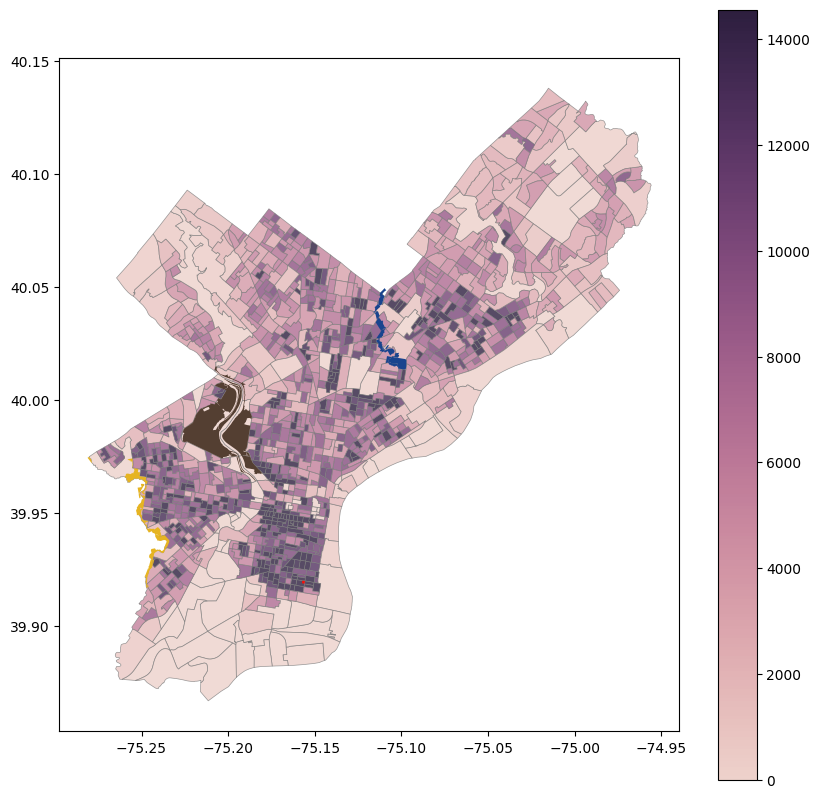

In [15]:
# Use 75th percentile as upper limit
upper_limit = merged_philly_23['pop_density'].quantile(0.85)
norm = colors.Normalize(vmin=0, vmax=upper_limit)

# load colormap
cmap = sns.cubehelix_palette(as_cmap=True)
#cmap = plt.cm.BuGn


# initialize the figure
fig, ax = plt.subplots(figsize=(10, 10))

# create the plot
merged_philly_23.plot(ax=ax, column='pop_density', cmap=cmap, edgecolor='gray', linewidth=0.5, alpha = 0.8, norm =norm, legend=True)

cobbscreek.plot(ax=ax, color='#e6b422', label='Cobbs Creek')
mifflin.plot(ax=ax, color='#F80E07', label='Mifflin Square')
tacony.plot(ax=ax, color='#19448e', label='Tacony')
fairmount.plot(ax=ax, color='#543f32', label='Fairmount')

plt.show()


## Add covar into the model

### 3-year 311 data

In [16]:
## load 2023 data
litter_23 = gpd.read_file('data/311/2023/public_cases_fc.shp')
## filter data
illegal_dumping_23 = litter_23[litter_23['service_na'] == "Illegal Dumping"]

In [17]:
## load 2022 data
litter_22 = gpd.read_file('data/311/2022/public_cases_fc.shp')
## filter data
illegal_dumping_22 = litter_22[litter_22['service_na'] == "Illegal Dumping"]

In [18]:
## load 2021 data
litter_21 = gpd.read_file('data/311/2021/public_cases_fc.shp')
## filter data
illegal_dumping_21 = litter_21[litter_21['service_na'] == "Illegal Dumping"]

In [19]:
## concact 2022, 2023, and 2024 data
illegal_dumping = pd.concat([illegal_dumping_21,illegal_dumping_22, illegal_dumping_23])

In [20]:
## list of parks
parks = {
    'cobbscreek': cobbscreek,
    'mifflin': mifflin,
    'tacony': tacony,
    'fairmount': fairmount
}

# set buffer value
buffer = 0.003

# collect results
all_parks_gdf = gpd.GeoDataFrame() # for plotting
all_boxes_gdf = gpd.GeoDataFrame() # for filtering

# loop: get boxes around 
for name, gdf in parks.items():
    # skip empty GeoDataFrames
    if gdf.empty:
        continue
    
    # store parks geometries
    all_parks_gdf = pd.concat([all_parks_gdf, gdf], ignore_index=True)

    # compute total bounds
    minx, miny, maxx, maxy = gdf.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer

    # compute the side length of the square
    side = max(maxx - minx, maxy - miny)
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    # create square box
    square_minx = center_x - side / 2
    square_maxx = center_x + side / 2
    square_miny = center_y - side / 2
    square_maxy = center_y + side / 2
    square_geom = box(square_minx, square_miny, square_maxx, square_maxy)

    # create GeoDataFrame for box
    square_gdf = gpd.GeoDataFrame(
        {'PARKNAME': [f"{name}_box"]},
        geometry=[square_geom],
        crs=gdf.crs
    )

    # add box to collection
    all_boxes_gdf = pd.concat([all_boxes_gdf, square_gdf], ignore_index=True)

In [21]:
illegal_dumping_parks_23 = illegal_dumping.sjoin(all_boxes_gdf, predicate='within')
illegal_dumping_parks_23 = illegal_dumping_parks_23.drop(columns='index_right')

illegal_dumping_parks_23 = illegal_dumping_parks_23.sjoin(merged_philly_23, predicate='within')
tacony_points_23 = illegal_dumping_parks_23[illegal_dumping_parks_23['PARKNAME'] == 'tacony_box']

In [22]:
# Create time windows throughout the day
time_windows = [
    (0, 14400),      # 12am-4am
    (14400, 28800),  # 4am-8am
    (28800, 43200),  # 8am-12pm
    (43200, 57600),  # 12pm-4pm
    (57600, 72000),  # 4pm-8pm
    (72000, 86400)   # 8pm-12am
]

# Calculate how many points to assign to each window
points_per_window = len(tacony_points_23) // len(time_windows)
remaining_points = len(tacony_points_23) % len(time_windows)

# Generate jittered times
jittered_times = []
for i, (start, end) in enumerate(time_windows):
    # Add extra points to first few windows if we have remainder
    n_points = points_per_window + (1 if i < remaining_points else 0)
    # Generate uniform random times within this window
    window_times = np.random.uniform(start, end, n_points)
    jittered_times.extend(window_times)

# Shuffle the times to avoid any ordering
np.random.shuffle(jittered_times)

# Apply the jittered times
tacony_points_23['jittered_time'] = tacony_points_23['requested_'] + \
    pd.to_timedelta(jittered_times, unit='s')

# get coordinates from the geometry
coords = pd.DataFrame({
    'x': tacony_points_23.geometry.centroid.x,
    'y': tacony_points_23.geometry.centroid.y
})

# calculate time difference in days from the minimum date
min_time = tacony_points_23['jittered_time'].min()
time_diff = (tacony_points_23['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)
tacony_points_23['time_diff'] = time_diff
month = tacony_points_23['jittered_time'].dt.month

# Create locs_s DataFrame
locs_s = pd.DataFrame({
    'X': coords['x'].astype(float),
    'Y': coords['y'].astype(float),
    'T': time_diff.astype(float)
   # 'month': month
})

/Users/yuxin/miniconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_48021/1144363592.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'x': tacony_points_23.geometry.centroid.x,
/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_48021/1144363592.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'y': tacon

In [23]:
# Calculate time differences between consecutive points
locs_s = locs_s.sort_values('T')
time_diffs = locs_s['T'].diff().fillna(0)

# Create jitter that's proportional to the time differences
# Use a fraction of the time difference as the jitter amount
jitter_fraction = 0.1  # Jitter will be 10% of the time difference
jitter = np.random.normal(0, time_diffs * jitter_fraction)

# Apply the jitter
locs_s['T'] = locs_s['T'] + jitter

# Ensure no negative times
locs_s['T'] = locs_s['T'].clip(lower=0)

# Sort by time again
locs_s = locs_s.sort_values('T')

# Reset index
locs_s = locs_s.reset_index(drop=True)

In [24]:
## add month indicator: by time difference
#locs_s['day_of_year'] = (locs_s['T'] % 365) + 1
#locs_s['date'] = pd.to_datetime('2001-01-01') + pd.to_timedelta(locs_s['day_of_year'] - 1, unit='D')
#locs_s['month'] = locs_s['date'].dt.month
#locs_s = locs_s.drop(['day_of_year','date'],axis = 1)


In [25]:
conditions = [
    locs_s['T'] < 365,                         # Year 1: T = 0 to 364
    (locs_s['T'] >= 365) & (locs_s['T'] < 730),   # Year 2: T = 365 to 729
    locs_s['T'] >= 730                        # Year 3: T = 730+
]

choices = [
    locs_s['T'],              # Year 1: no subtraction
    locs_s['T'] - 365,        # Year 2: subtract 365
    locs_s['T'] - 730         # Year 3: subtract 2*365
]

locs_s['day'] = np.select(conditions, choices)

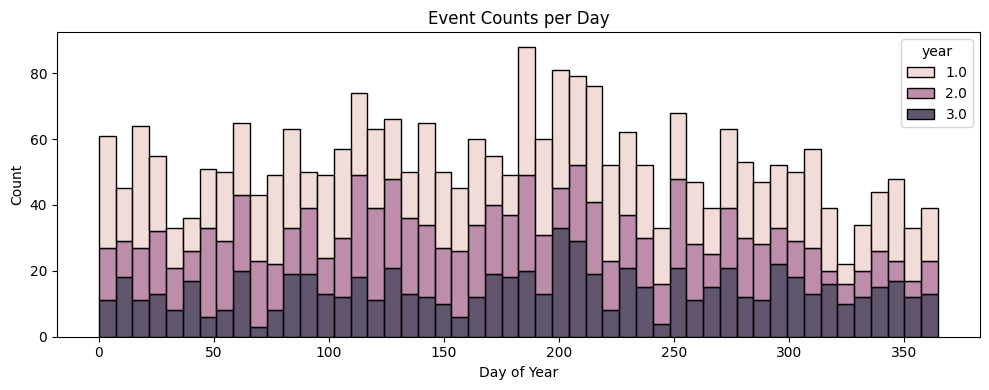

In [43]:

plt.figure(figsize=(10, 4))
sns.histplot(data=locs_s, x='day', bins=50, hue='year', multiple='stack')
plt.xlabel("Day of Year")
plt.title("Event Counts per Day")
plt.tight_layout()
plt.show()


In [26]:
#locs_s.iloc[1100:].head()

In [27]:
## prepare cover dataset
cover_23 = merged_philly_23[['pop_density', 'med_inc_avg','lep_density','med_age_21','edu_hs_avg','geometry']]

In [28]:
## Cox-Hawkes model
# a_0 = baseline log-intensity
# alpha = magnitute of excitation
# bate = temporal trigger param
# sigmax_2 = spatial trigger param
column_names = ['pop_density','med_inc_avg', 'lep_density', 'med_age_21','edu_hs_avg']

model = Hawkes_Model(locs_s,#spatiotemporal points
                     all_boxes_gdf[all_boxes_gdf['PARKNAME']=='tacony_box'],#philly boundaries
                     1095,#Time frame 
                     True,#use Cox as background
                     spatial_cov=cover_23,#spatial covariate matrix
                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(0,2), 
                     # alpha = dist.Beta(20,60),#set priors
                     alpha = dist.Beta(2,2),
                     # beta=dist.HalfNormal(2.0),
                     beta=dist.HalfNormal(1.0),
                     sigmax_2=dist.HalfNormal(0.25)
                    )

/Users/yuxin/BSTPP/bstpp/main.py:129: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))
/Users/yuxin/miniconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yuxin/miniconda3/lib/python3.12/site-packages/pandas/core/generic.py:6313: DeprecationWarning: Overriding the CRS of a GeoDataFrame that already has CRS. This unsafe behavior will be deprecated in future versions. Use GeoDataFrame.set_crs method instead
  return object.__setattr__(self, name, val

In [29]:
model.args['indices_d'] = locs_s['day'].values
model.args['n_days'] = 365 

[DEBUG] set_window called with:
  window type: <class 'float'> value: 8.2
  spatial_window type: <class 'float'> value: 0.25
[DEBUG] aligned_difference_pairs called with:
  t type: <class 'numpy.ndarray'> dtype: float64 shape: (2666,)
  x type: <class 'numpy.ndarray'> dtype: float64 shape: (2666,)
  y type: <class 'numpy.ndarray'> dtype: float64 shape: (2666,)
  window type: <class 'float'> value: 8.2
  spatial_window type: <class 'float'> value: 0.25
[set_window] Temporal window set to: 8.2
[set_window] Number of events: 2666
[set_window] Number of pairs: 218017
[set_window] Max t_diff in pairs: 8.199797973955398
[set_window] Min t_diff in pairs: 9.050097599327955e-06
[set_window] All t_diff <= window: True
[set_window] All t_diff > 0: True
[set_window] Spatial window set to: 0.25
[set_window] Max spatial distance: 0.24999940395355225
[set_window] Min spatial distance: 0.0
[set_window] All spatial distances <= window: True


100%|██████████| 5000/5000 [00:28<00:00, 175.61it/s, init loss: -8585.1094, avg. loss [4751-5000]: -24095.7809]


Number of posterior samples: 1000
Number of pairs: 218017
coords shape: (218017, 2)

SVI elapsed time: 38.18073391914368


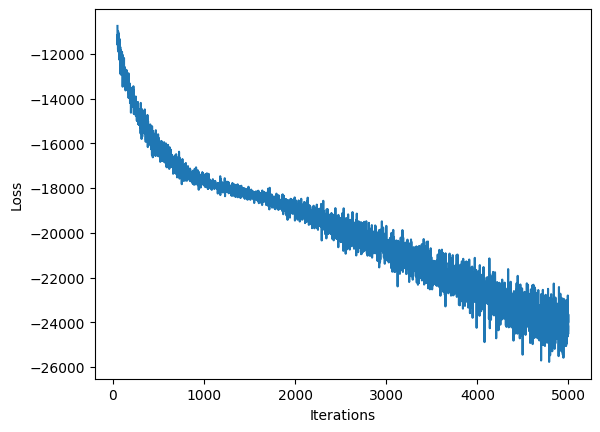

In [30]:
model.set_window(window = 8.2, spatial_window= 0.25)  ## 180 days window
model.run_svi(lr=0.005,num_steps=5000) # less interations and bigger learning rate

,Post Mean,Post Std,P(w>0),[0.025,0.975]
pop_density,0.319435,0.052893,1.000,0.215162,0.417283
med_inc_avg,-0.161019,0.046464,0.001,-0.254050,-0.072425
lep_density,-0.043274,0.069271,0.263,-0.175790,0.097225
med_age_21,0.222947,0.035014,1.000,0.154133,0.292492
edu_hs_avg,0.016492,0.043668,0.639,-0.070506,0.101524
a_0,2.129734,0.091208,1.000,1.946100,2.301071


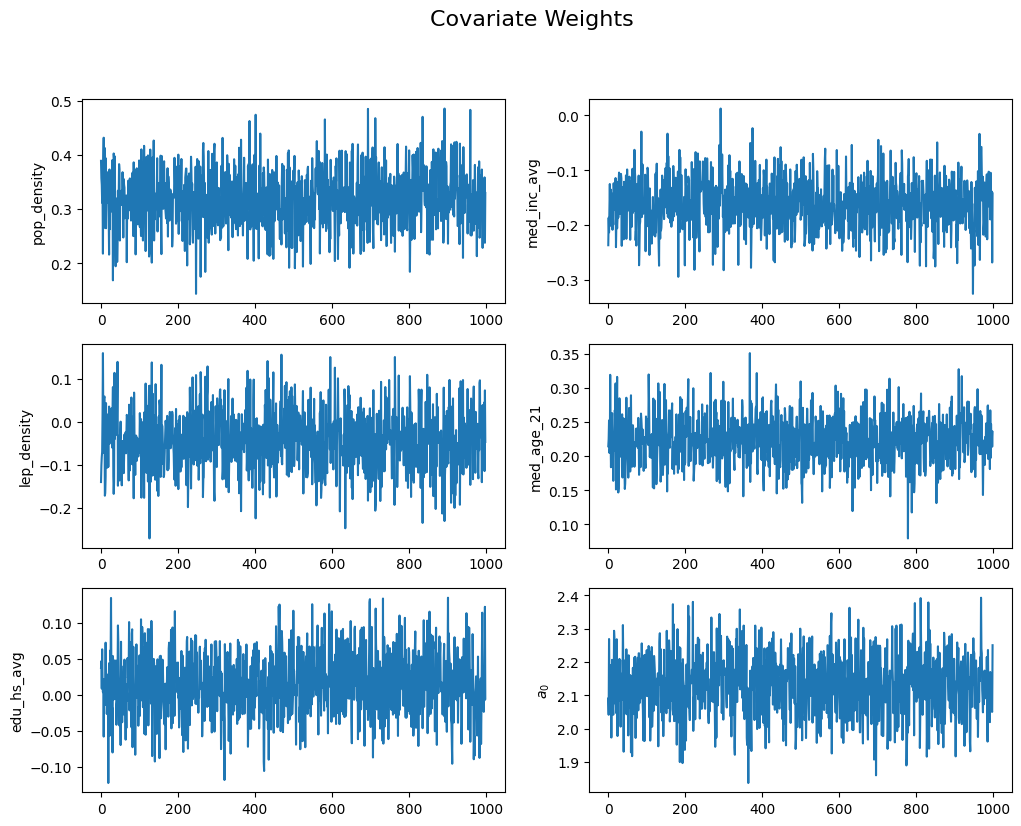

In [31]:
model.cov_weight_post_summary(trace=True)

In [32]:
model.log_expected_likelihood(locs_s)

Final test_args keys: ['T', 't_min', 'x_min', 'x_max', 'y_min', 'y_max', 'model', 'A_area', 'A_', 'n_t', 'x_t', 'n_xy', 'spatial_grid_cells', 't_events', 'indices_t', 'indices_xy', 'xy_events', 'gp_kernel', 'hidden_dim_temporal', 'z_dim_temporal', 'hidden_dim1_spatial', 'hidden_dim2_spatial', 'z_dim_spatial', 'decoder_params_temporal', 'decoder_params_spatial', 'cov_ind', 'num_cov', 'spatial_cov', 'int_df', 'sp_var_mu', 'priors', 't_trig', 'sp_trig', 'indices_d', 'n_days', 'window', 'spatial_window', 'coords', 't_vals', 'x_vals', 'y_vals']


13186.8828125

In [33]:
model.expected_AIC()

-23559.548828125

0.5634283423423767

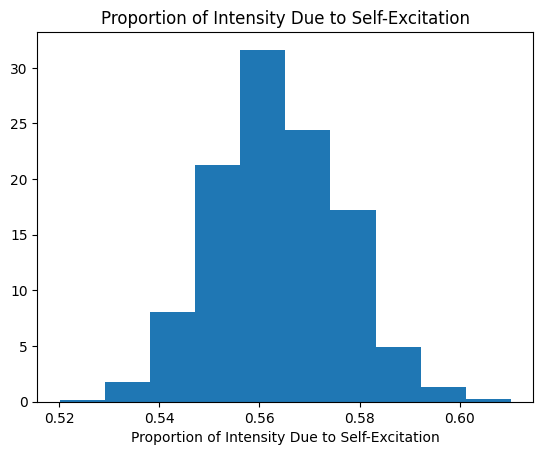

In [34]:
model.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,0.580845,0.016269,1.0,0.548690,0.612510
beta,1.856867,0.117199,1.0,1.640822,2.083447
sigmax_2,0.000024,0.000012,1.0,0.000008,0.000052


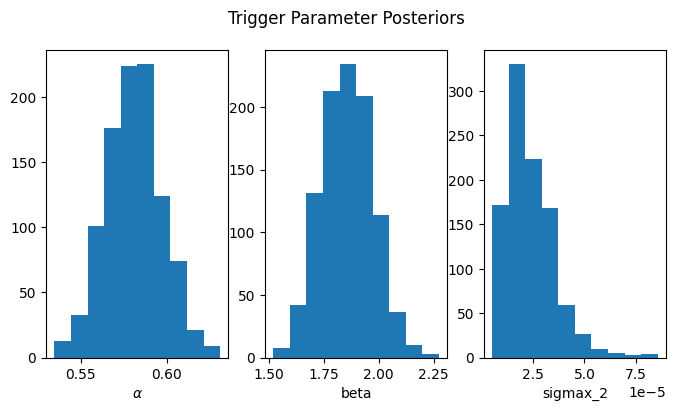

In [35]:
model.plot_trigger_posterior(trace=False)

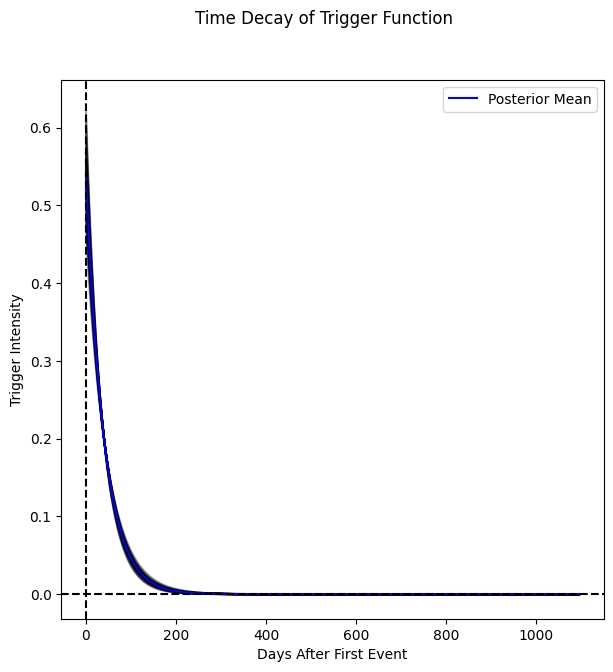

<Figure size 640x480 with 0 Axes>

In [36]:
model.plot_trigger_time_decay()
plt.gcf()

# Show the plot
plt.show()

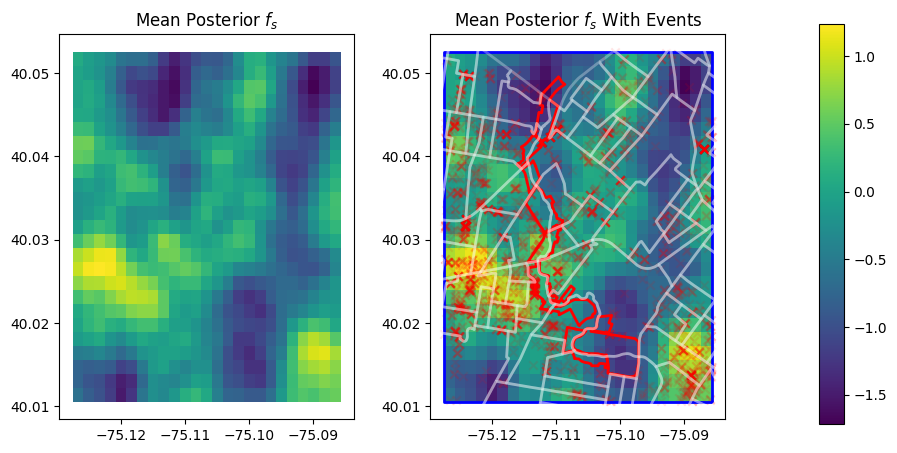

In [37]:
model.plot_spatial(include_cov=False)

# Get all axes in the figure
fig = plt.gcf()
axs = fig.get_axes()

# Match limits from left subplot
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

# Try plotting on the second subplot (with events)
all_boxes_gdf.plot(ax=axs[1], edgecolor='blue', facecolor='none', linewidth=2)
#philly_border.plot(ax=axs[1], edgecolor='red', facecolor='none', linewidth=2)
all_parks_gdf.plot(ax=axs[1], edgecolor='#FF0000', facecolor='none', linewidth=2)
philly_2023.plot(ax=axs[1], edgecolor='white', facecolor='none', linewidth=2, alpha = 0.3)


# Set the same limits on the right subplot
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

# Save and show
#plt.savefig('output/spatial_trigger_tcn.png', dpi=450, bbox_inches='tight')
plt.show()

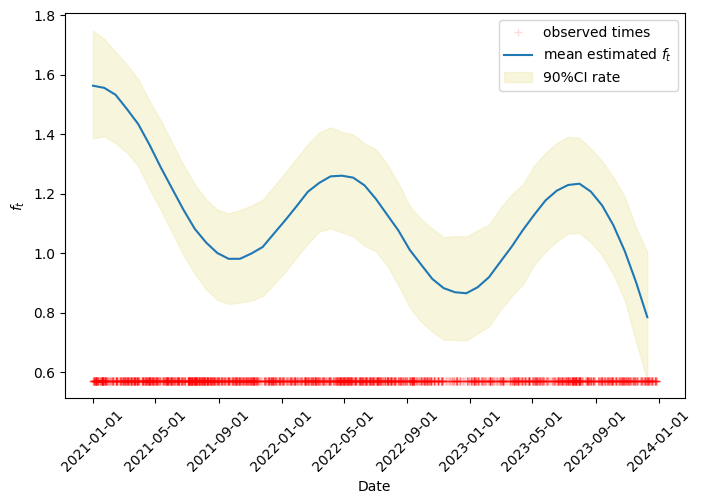

In [38]:
model.plot_temp_date(start_date='2021-01-01')


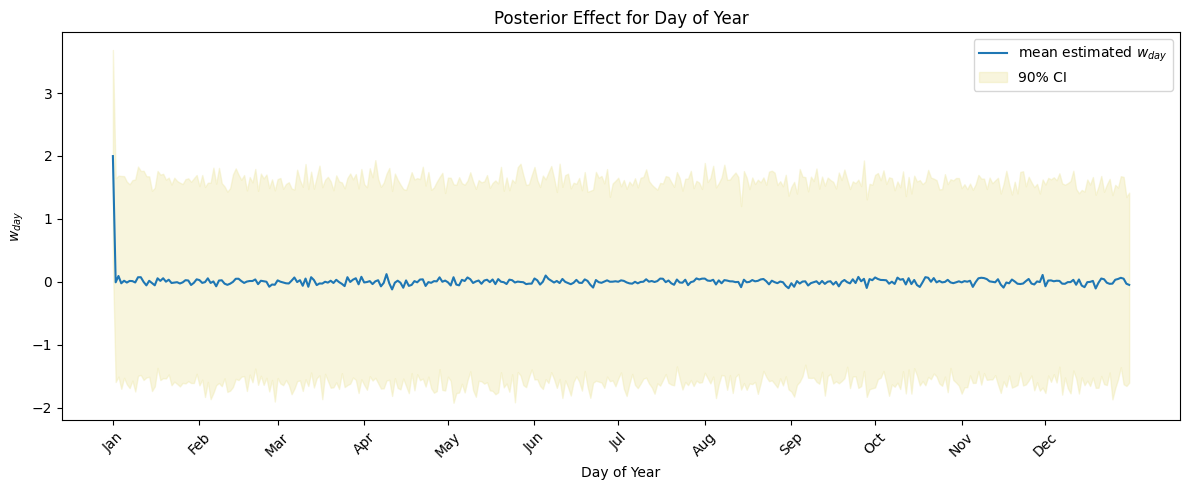

In [39]:
model.plot_day_effect()
#plt.savefig('output/spatial_month_gp.png', dpi=450, bbox_inches='tight')
